## Title: Parameter Screening Data Analysis

#### Author: Nilay Kumar
Multicellular Systems Engineering Lab

Department of Chemical and Biomolecular Engineering

University of Notre Dame
#### Summary
This notebook is used for analying the data generated by init.py and main.py , which use Signac flow for sampling parameters of the surface evolver model and running it to obtain the minimal energy shape. The code puts together numpy arrays from signac datafiles for further analysis and use. This partcular notebook analyzes 5 dummy data generated using the screening. 

In [1]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import spatial_efd
import math 
import signac
import numpy as np
import os.path
import similaritymeasures

In [2]:
# Defining number of input parameters and number of outputs in the feature 
num_samples = 5
num_harmonics = 20
num_input_parameter = 35

#### 1. Exploring signac workspace and constructing input output data for Gaussian Process Regression modeling and Bayesian Optimization

In [3]:
# Fetching project from signac workspace
project = signac.get_project()

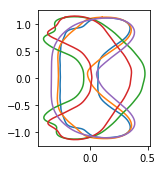

In [4]:
""" This section of the code does the following tasks
1. Creating input and output training data for building surrogate models
2. The input data is stored in master_parameter_input array with shape [num_samples,num_parameters]
3. The output data is stored in master_parameter_output array with shape [num samples, 4 x num_harmonics]
4. The section additionally plots wing imaginal disc shape through reverse EFD  as a result of changes made in the parameter
"""

fig, ax = plt.subplots(figsize=(2, 2.5))
plt.rcParams.update({'font.size': 10})

# Checking if data exists
doesDataFileExist = os.path.isfile("master_feature_output.npy")

# Loading datafiles if they exist
# Else fetching and preparing data from signac workspace
if doesDataFileExist == True:
    # Loading input parameters
    master_parameter_input_n = np.load('master_parameter_input_n.npy', )
    # Loading output EFD coefficients
    master_feature_output = np.load('master_feature_output.npy', )
else:
    # Initializing input and output data
    master_parameter_input = np.zeros([1, 35])
    master_feature_output = np.zeros([1,80])

    # Itearting throgh each job in workspace
    for job in project:

        isFile = os.path.isfile(job.fn("signac_job_document.json"))
        if isFile == True:
            # Fetching input parameters from the .json file containing setpoints
            input_param = job.statepoint()["parameter_model"]
            # Coverting array to a numpy array
            input_param = np.array(input_param)
            # Reshaping the array to concatenate to the master input 
            input_param_reshaped = np.reshape(input_param, (1, len(input_param)))
            # Vertical concatenation of the job specific input parameter list to the mster input data
            master_parameter_input = np.vstack((master_parameter_input,input_param_reshaped))

            # Fetching efd coefficients from the output data in signac
            efd_coeff = job.document.get("e_f_d")
            # Converting to numpy array
            efd_coeff = np.array(efd_coeff)
            # Converting efd coeff to xy data for visualization
            xt, yt = spatial_efd.inverse_transform(efd_coeff, harmonic=20)
            ax.plot(xt,yt)
            # plt.axes().set_aspect('equal', 'datalim')
            # Reshaping efd coeff in a shape of a row 
            efd_coeff = np.reshape(efd_coeff, (1,80))
            # Stacking output features for creating a master output feature matrix
            master_feature_output = np.vstack((master_feature_output,efd_coeff))


    # plt.legend(loc='upper left',ncol = 2, prop={'size': 6})      
    plt.show()

    # Deleting the first row containing zeros
    master_feature_output = np.delete(master_feature_output, 0, 0)
    master_parameter_input = np.delete(master_parameter_input, 0, 0)

    # Renaming files for saving
    master_feature_output_2 = master_feature_output
    master_parameter_input_2 = master_parameter_input
    
    # saving files 
    np.save('master_parameter_input_2.npy', master_parameter_input_2)
    np.save('master_feature_output_2.npy', master_feature_output_2)



__Figure 1: Barplots describing sensitivities of all the measured geometrical features upon perturbation of model parameters.__  A total of 16 geometrical features whose sensitivity is measures are listed as heading of each subplot. Labels in the x axis of each plot represent the model parameters that were varied against which the sensitivity was cmputed.*Note: Log of absolute value of sensitivity has been plotted*

In [ ]:
""" # This section of code is useful when we have to merge a new data from workspace to existing datafile

master_parameter_input_1 = np.load('master_parameter_input_1.npy', )
master_feature_output_1 = np.load('master_feature_output_1.npy', )

master_parameter_input_2 = np.load('master_parameter_input_2.npy', )
master_feature_output_2 = np.load('master_feature_output_2.npy', )

# Combining data from multiple parameter screens
master_parameter_input_n = np.vstack((master_parameter_input_1,master_parameter_input_2))
master_feature_output = np.vstack((master_feature_output_1,master_feature_output_2))
np.save('master_parameter_input_n.npy', master_parameter_input_n)
np.save('master_feature_output.npy', master_feature_output)
"""